<a href="https://colab.research.google.com/github/Ankit9424-prog/CIFAR-10-classification/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CIFAR10 classification

In [1]:
#import necessary libraries
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Import the data

In [3]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
len(train_data), len(test_data)

(50000, 10000)

In [5]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [6]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

###Visualize the data


Image shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, '6')

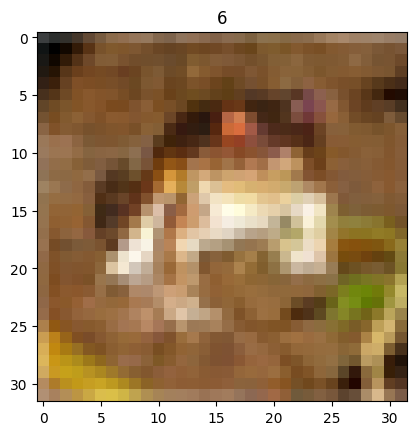

In [7]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

##Create dataloader

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,
                              batch_size = 32,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False)

In [9]:
print(f"Dataloader: {train_dataloader}\nLength: {len(train_dataloader)}")
print(f"Dataloader: {test_dataloader}\nLength: {len(test_dataloader)}")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7e93e8fe1d90>
Length: 1563
Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7e93e8f7df10>
Length: 313


# Task
Define a convolutional neural network (CNN) architecture for image classification, including convolutional, pooling, and fully connected layers.


In [10]:
class ImageClassfication(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*8*8,
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.classifier(x)
    return x

##Define loss function and optimizer

In [11]:
model = ImageClassfication(input_shape=3,
                            hidden_units=64, # Increased hidden_units
                            output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(params=model.parameters(),
                              lr=0.001)

##Define the traning function


In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss =  loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad() # Corrected: added parentheses

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss /len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

##Define the evaluation function


In [13]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device = device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      test_acc += (test_pred_class == y).sum().item()/len(test_pred_class)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

##Define the traning loop

In [14]:
epochs = 8  #For now i have done 8 epochs, for better accuracy you can increase it.
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(epochs):
  train_loss, train_acc = train_step(model=model,
                                     dataloader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device)
  test_loss, test_acc = test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  optimizer=optimizer,
                                  device=device)

  print(f"Epochs: {epoch+1} |"
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc:.4f}")

  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)

Epochs: 1 |train_loss: 1.4683 |train_acc: 0.4719 |test_loss: 1.1530 |test_acc: 0.5883
Epochs: 2 |train_loss: 1.0104 |train_acc: 0.6437 |test_loss: 0.9565 |test_acc: 0.6655
Epochs: 3 |train_loss: 0.8472 |train_acc: 0.7060 |test_loss: 0.8624 |test_acc: 0.6970
Epochs: 4 |train_loss: 0.7538 |train_acc: 0.7375 |test_loss: 0.8316 |test_acc: 0.7182
Epochs: 5 |train_loss: 0.6830 |train_acc: 0.7618 |test_loss: 0.8050 |test_acc: 0.7187
Epochs: 6 |train_loss: 0.6303 |train_acc: 0.7800 |test_loss: 0.8257 |test_acc: 0.7187
Epochs: 7 |train_loss: 0.5795 |train_acc: 0.7976 |test_loss: 0.8052 |test_acc: 0.7286
Epochs: 8 |train_loss: 0.5310 |train_acc: 0.8149 |test_loss: 0.7908 |test_acc: 0.7410


##Visualize the traning result

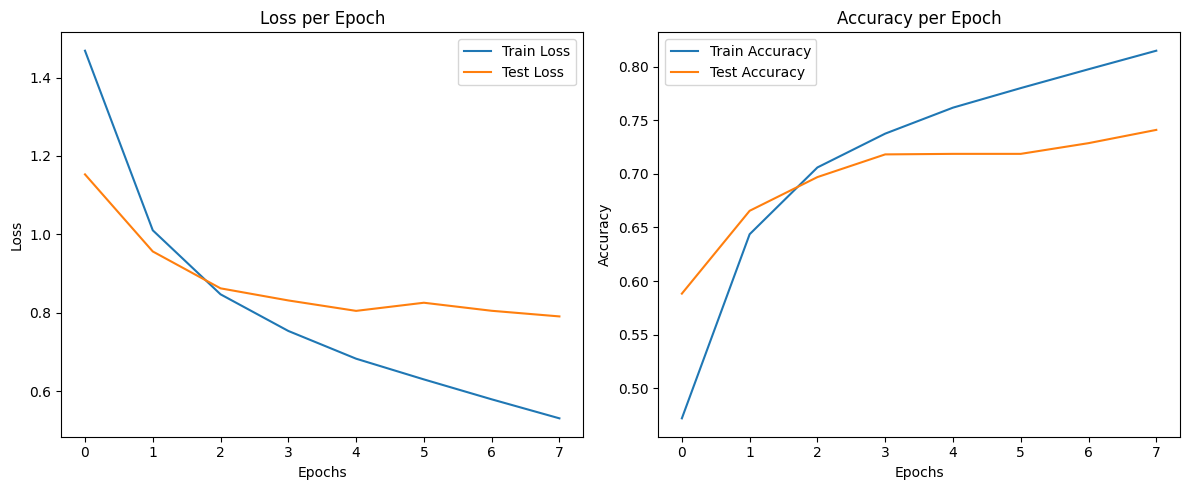

In [15]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['test_loss'], label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Making Predictions with the Trained Model



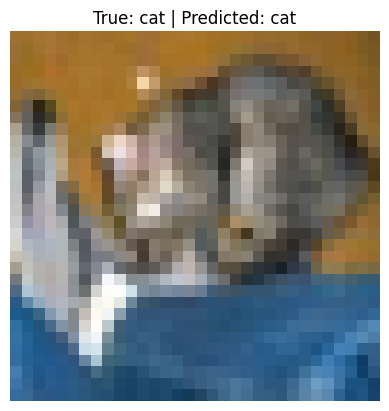

Predicted class: cat
True class: cat


In [16]:
# Get a sample image and label from the test data
img, true_label = test_data[0]

# Put model in eval mode
model.eval()

# Make prediction with inference mode
with torch.inference_mode():
    # Add an extra dimension to the image (batch size of 1)
    # and send it to the target device
    img_to_predict = img.unsqueeze(dim=0).to(device)
    prediction_logits = model(img_to_predict)

# Get prediction probability
prediction_prob = torch.softmax(prediction_logits, dim=1)

# Get prediction label
prediction_label = torch.argmax(prediction_prob, dim=1).item()

# Convert to class name
predicted_class_name = class_names[prediction_label]
true_class_name = class_names[true_label]

# Plot the image and print prediction results
plt.imshow(img.permute(1, 2, 0), interpolation='nearest') # Added interpolation='nearest'
plt.title(f"True: {true_class_name} | Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class_name}")
print(f"True class: {true_class_name}")

In [17]:
model.eval()
y_pred_list = []
with torch.inference_mode():
    for X_test, y_test in test_dataloader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_logits = model(X_test)
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        y_pred_list.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_pred_list)
print(y_pred_tensor)

tensor([3, 8, 8,  ..., 5, 0, 7])


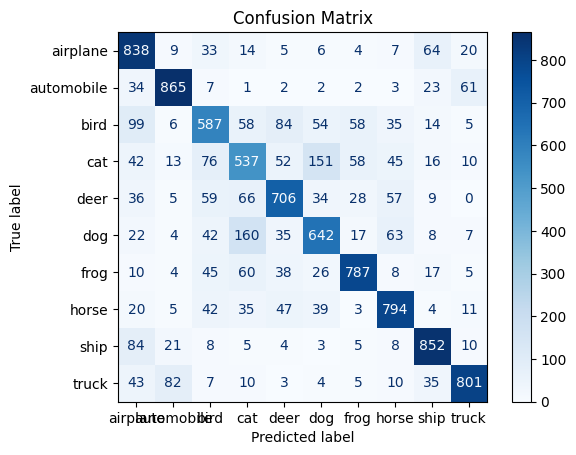

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Collect true labels from test_data
y_true = []
for _, label in test_data:
    y_true.append(label)
y_true_tensor = torch.tensor(y_true)

# y_pred_list is available from the previous cell's execution
y_pred_tensor = torch.cat(y_pred_list)

# Calculate confusion matrix using sklearn
cm = confusion_matrix(y_true_tensor.numpy(), y_pred_tensor.numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()